## 데이터 수집

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl # 한글 폰트 설정 (NanumGothic) 
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
import seaborn as sns
import pandas as pd
import numpy as np 
import scipy.stats as stats
from sklearn import datasets 
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from copy import deepcopy
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

import lightgbm as lgb

In [2]:
import matplotlib.font_manager as fm
# 폰트 캐시 삭제 및 재생성
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
fm._load_fontmanager(try_read_cache=False)

# 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = font_prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
data_df = pd.read_csv('../../datasets/customer-segmentation_Train.csv')
data_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


## 데이터 분석

In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [5]:
data_df['Work_Experience'].value_counts()

Work_Experience
1.0     2354
0.0     2318
9.0      474
8.0      463
2.0      286
3.0      255
4.0      253
6.0      204
7.0      196
5.0      194
10.0      53
11.0      50
12.0      48
13.0      46
14.0      45
Name: count, dtype: int64

In [6]:
def split_categorical_numerical(df, unique_threshold=0.001):
    """
    데이터프레임을 범주형과 수치형으로 분리
    
    Parameters:
    - df: 입력 데이터프레임
    - unique_threshold: unique 값 비율 임계값 (기본값 0.05 = 5%)
    
    Returns:
    - categorical_df: 범주형 컬럼만 있는 데이터프레임
    - numerical_df: 수치형 컬럼만 있는 데이터프레임
    """
    
    categorical_cols = []
    numerical_cols = []
    
    n_rows = len(df)
    
    for col in df.columns:
        # unique 값의 비율 계산
        unique_ratio = len(df[col].unique()) / n_rows
        n_unique = df[col].nunique()
        # object 타입이거나, unique 값 비율이 임계값보다 작으면 범주형으로 분류
        # df[col].dtype == 'object' or
        # if unique_ratio < unique_threshold:
        if n_unique < 30:  
            # print(f'cat - {col} : {n_unique}, {unique_ratio}')
            categorical_cols.append(col)
        else:
            # print(f'num - {col} : {n_unique}, {unique_ratio}')
            numerical_cols.append(col)
            
    return df[categorical_cols], df[numerical_cols]

In [7]:
cat_df, num_df = split_categorical_numerical(data_df)
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   object 
 1   Ever_Married     7928 non-null   object 
 2   Graduated        7990 non-null   object 
 3   Profession       7944 non-null   object 
 4   Work_Experience  7239 non-null   float64
 5   Spending_Score   8068 non-null   object 
 6   Family_Size      7733 non-null   float64
 7   Var_1            7992 non-null   object 
 8   Segmentation     8068 non-null   object 
dtypes: float64(2), object(7)
memory usage: 567.4+ KB


In [8]:
num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      8068 non-null   int64
 1   Age     8068 non-null   int64
dtypes: int64(2)
memory usage: 126.2 KB


## 데이터 전처리 

In [9]:
# 제외컬럼 처리
remove_columns = ['ID', 'Segmentation'] # 'Profession', 'Var_1',
missing_columns = ['Ever_Married', 'Graduated', 'Work_Experience', 'Family_Size', 'Profession', 'Var_1'] 
final_lable_columns = ['Segmentation']

In [10]:
remove_df = data_df.drop(columns=remove_columns)
remove_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   object 
 1   Ever_Married     7928 non-null   object 
 2   Age              8068 non-null   int64  
 3   Graduated        7990 non-null   object 
 4   Profession       7944 non-null   object 
 5   Work_Experience  7239 non-null   float64
 6   Spending_Score   8068 non-null   object 
 7   Family_Size      7733 non-null   float64
 8   Var_1            7992 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 567.4+ KB


In [11]:
missing_df = remove_df.drop(columns=missing_columns)
missing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          8068 non-null   object
 1   Age             8068 non-null   int64 
 2   Spending_Score  8068 non-null   object
dtypes: int64(1), object(2)
memory usage: 189.2+ KB


In [12]:
data_df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 6665 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               6665 non-null   int64  
 1   Gender           6665 non-null   object 
 2   Ever_Married     6665 non-null   object 
 3   Age              6665 non-null   int64  
 4   Graduated        6665 non-null   object 
 5   Profession       6665 non-null   object 
 6   Work_Experience  6665 non-null   float64
 7   Spending_Score   6665 non-null   object 
 8   Family_Size      6665 non-null   float64
 9   Var_1            6665 non-null   object 
 10  Segmentation     6665 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 624.8+ KB


In [13]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))


In [14]:
for target_col in missing_columns:
    for col in data_df.columns:
        correlation = cramers_v(data_df[target_col], data_df[col])
        print(f"{target_col} - {col} : {correlation}")


Ever_Married - ID : 1.0
Ever_Married - Gender : 0.1158780982735355
Ever_Married - Ever_Married : 0.9997401040042931
Ever_Married - Age : 0.6378938304924608
Ever_Married - Graduated : 0.1966260001320954
Ever_Married - Profession : 0.5188219863634007
Ever_Married - Work_Experience : 0.1072883100910616
Ever_Married - Spending_Score : 0.6763317252705825
Ever_Married - Family_Size : 0.32245578809833053
Ever_Married - Var_1 : 0.10477089601507167
Ever_Married - Segmentation : 0.4217598733952146
Graduated - ID : 1.0
Graduated - Gender : 0.03385002477988003
Graduated - Ever_Married : 0.1966260001320954
Graduated - Age : 0.4728862849520829
Graduated - Graduated : 0.9997339025354592
Graduated - Profession : 0.4075793694864259
Graduated - Work_Experience : 0.04510384442862869
Graduated - Spending_Score : 0.15287463349686686
Graduated - Family_Size : 0.24132225438758478
Graduated - Var_1 : 0.22343986591497206
Graduated - Segmentation : 0.3654957583591485
Work_Experience - ID : 0.9999999999999999
Wo

### 결측치 처리

In [15]:
missing_df = remove_df.dropna()
missing_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6665 entries, 0 to 8067
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           6665 non-null   object 
 1   Ever_Married     6665 non-null   object 
 2   Age              6665 non-null   int64  
 3   Graduated        6665 non-null   object 
 4   Profession       6665 non-null   object 
 5   Work_Experience  6665 non-null   float64
 6   Spending_Score   6665 non-null   object 
 7   Family_Size      6665 non-null   float64
 8   Var_1            6665 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 520.7+ KB


### 이상치 처리

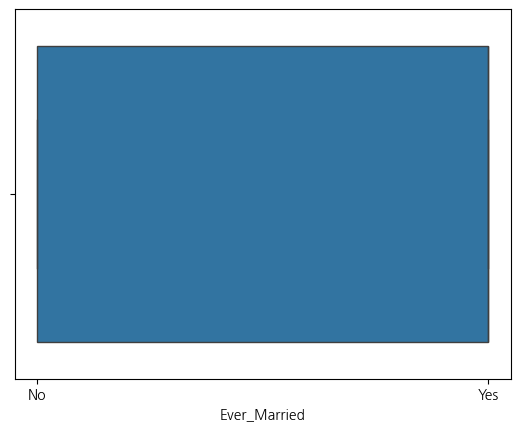

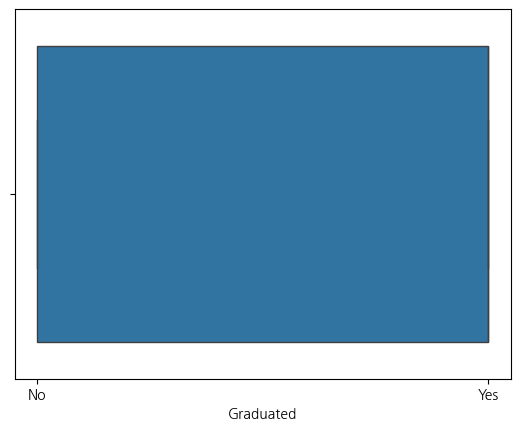

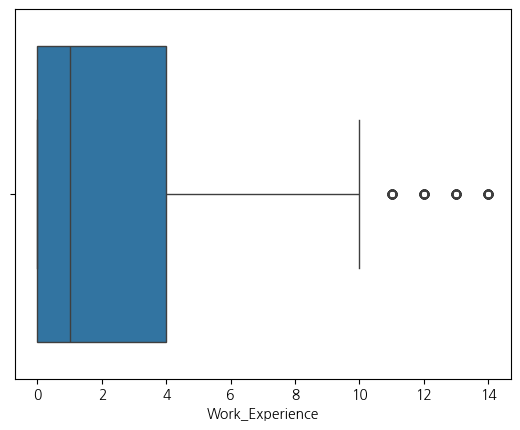

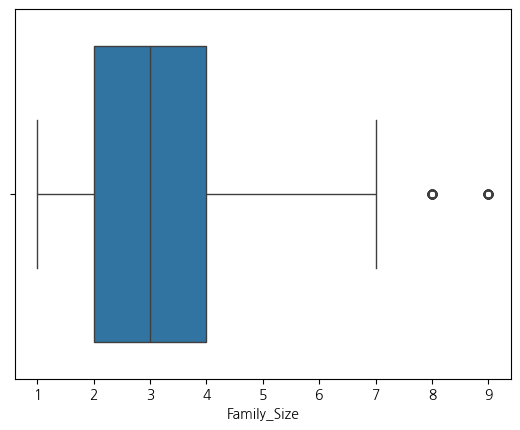

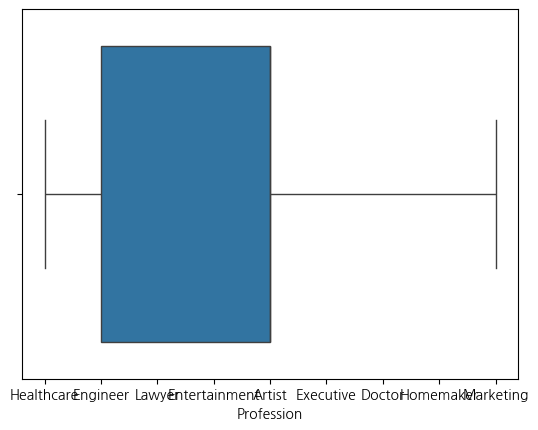

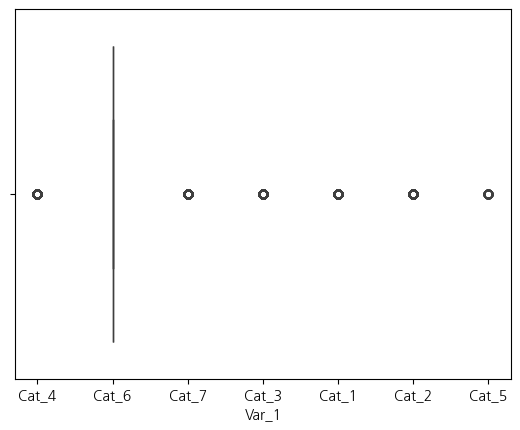

In [16]:
for col in missing_columns:
    sns.boxplot(data=data_df, x=col)
    plt.show()

### 범주형 처리

In [17]:
cat_df, num_df = split_categorical_numerical(missing_df)
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6665 entries, 0 to 8067
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           6665 non-null   object 
 1   Ever_Married     6665 non-null   object 
 2   Graduated        6665 non-null   object 
 3   Profession       6665 non-null   object 
 4   Work_Experience  6665 non-null   float64
 5   Spending_Score   6665 non-null   object 
 6   Family_Size      6665 non-null   float64
 7   Var_1            6665 non-null   object 
dtypes: float64(2), object(6)
memory usage: 468.6+ KB


In [18]:
num_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6665 entries, 0 to 8067
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Age     6665 non-null   int64
dtypes: int64(1)
memory usage: 104.1 KB


In [19]:
def run_onehotencode(data_df, model=OneHotEncoder()):

    columns = data_df.columns
    model_list = []
    for col in columns :
        model.fit(X=data_df[[col]])
        model_list.append(deepcopy(model))
        encoded_pclass = model.transform(X=data_df[[col]]).toarray()
        pclass_name_list = model.get_feature_names_out(input_features=[col])
        pclass_df = pd.DataFrame(data=encoded_pclass, columns=pclass_name_list, index=data_df.index)
        # 원본 자르는거 추가 

        data_df = pd.concat([data_df.drop(columns=[col]), pclass_df], axis=1)

    return data_df, model_list

In [20]:
onehot_df, model_list = run_onehotencode(cat_df)
onehot_df = pd.concat([onehot_df, num_df], axis=1)
onehot_df.head()

,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,...,Family_Size_8.0,Family_Size_9.0,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Age
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,22
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,67
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,67
5,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,56
6,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,32


In [21]:
onehot_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6665 entries, 0 to 8067
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Gender_Female             6665 non-null   float64
 1   Gender_Male               6665 non-null   float64
 2   Ever_Married_No           6665 non-null   float64
 3   Ever_Married_Yes          6665 non-null   float64
 4   Graduated_No              6665 non-null   float64
 5   Graduated_Yes             6665 non-null   float64
 6   Profession_Artist         6665 non-null   float64
 7   Profession_Doctor         6665 non-null   float64
 8   Profession_Engineer       6665 non-null   float64
 9   Profession_Entertainment  6665 non-null   float64
 10  Profession_Executive      6665 non-null   float64
 11  Profession_Healthcare     6665 non-null   float64
 12  Profession_Homemaker      6665 non-null   float64
 13  Profession_Lawyer         6665 non-null   float64
 14  Profession_Ma

### 스케일링


In [22]:
standardscaler = StandardScaler()
standardscaler.fit(onehot_df)

StandardScaler()

In [23]:
# 스케일링 적용
scaling_array = standardscaler.transform(onehot_df)
# 스케일링된 데이터를 DataFrame으로 변환
scaling_df = pd.DataFrame(scaling_array, columns=onehot_df.columns)
scaling_df.head()

,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,...,Family_Size_8.0,Family_Size_9.0,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Age
0,-0.901454,0.901454,1.203938,-1.203938,1.326157,-1.326157,-0.700037,-0.312219,-0.309316,-0.371684,...,-0.079634,-0.075724,-0.125902,-0.239652,-0.324228,2.617329,-0.10596,-1.429954,-0.15982,-1.303415
1,1.109319,-1.109319,-0.830607,0.830607,-0.754059,0.754059,-0.700037,-0.312219,3.232938,-0.371684,...,-0.079634,-0.075724,-0.125902,-0.239652,-0.324228,-0.382069,-0.10596,0.699323,-0.15982,1.420092
2,-0.901454,0.901454,-0.830607,0.830607,-0.754059,0.754059,-0.700037,-0.312219,-0.309316,-0.371684,...,-0.079634,-0.075724,-0.125902,-0.239652,-0.324228,-0.382069,-0.10596,0.699323,-0.15982,1.420092
3,-0.901454,0.901454,-0.830607,0.830607,1.326157,-1.326157,1.428496,-0.312219,-0.309316,-0.371684,...,-0.079634,-0.075724,-0.125902,-0.239652,-0.324228,-0.382069,-0.10596,0.699323,-0.15982,0.754346
4,-0.901454,0.901454,1.203938,-1.203938,-0.754059,0.754059,-0.700037,-0.312219,-0.309316,-0.371684,...,-0.079634,-0.075724,-0.125902,-0.239652,-0.324228,-0.382069,-0.10596,0.699323,-0.15982,-0.698191


### 차원 축소

In [24]:
dim_reduction_PCA = PCA(n_components=2) # 줄일 목표차원의 차원수 2차원으로 축소
feature_pca = dim_reduction_PCA.fit_transform(X=scaling_df)

dim_reduction_PCA.explained_variance_ratio_, dim_reduction_PCA.explained_variance_ # 92% vs 5%

(array([0.09074151, 0.05335423]), array([4.53775639, 2.66811197]))

In [25]:
scaling_df.shape, feature_pca.shape

((6665, 50), (6665, 2))

### 리샘플링

## 데이터 분할

## 모델 학습 

In [26]:
# 차원 축소 안했을 때 : 50차원
result_list = []
for num in range(2,11):
    model_number = KMeans(n_clusters=num, n_init=10)
    model_number.fit(X=scaling_df)
    result_list.append(model_number.inertia_)
    
result_list

[308379.46375999384,
 298694.46474094194,
 288445.460692475,
 281943.79428315,
 274557.46660899254,
 270363.10714041983,
 262037.81433393643,
 256033.23738657078,
 250146.06152607515]

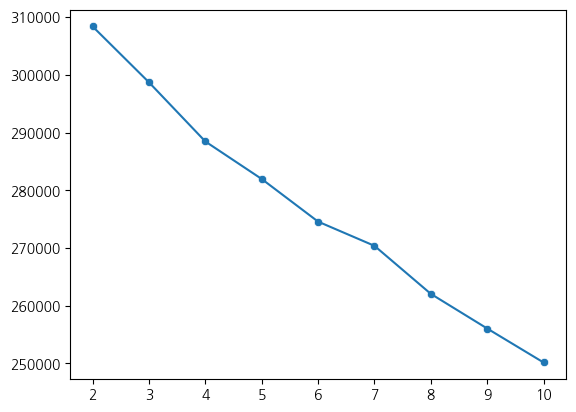

In [27]:
# 차원 축소 안했을 때 : 50차원
sns.scatterplot(x=range(2,11), y=result_list)
sns.lineplot(x=range(2,11), y=result_list)
plt.show()

In [28]:
# 차원 축소 강하게 했을 때 : 2차원
result_list = []
for num in range(2,11):
    model_number = KMeans(n_clusters=num, n_init=10)
    model_number.fit(X=feature_pca)
    result_list.append(model_number.inertia_)
    
result_list

[23816.28848597382,
 15616.295393480903,
 10253.645521162643,
 8639.755415672853,
 7281.0054968341665,
 6105.66498242298,
 5374.799506212091,
 4825.679318615559,
 4364.361192886105]

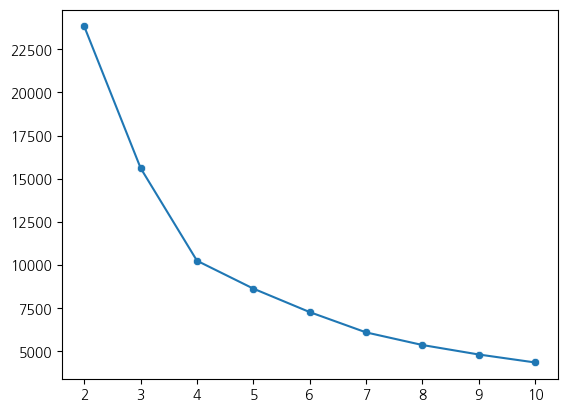

In [29]:
sns.scatterplot(x=range(2,11), y=result_list)
sns.lineplot(x=range(2,11), y=result_list)
plt.show()

In [30]:
# 최종 학습 모델 : 2차원, n_clusters=4

model_number = KMeans(n_clusters=4, n_init=10)
model_number.fit(X=feature_pca)

KMeans(n_clusters=4, n_init=10)

## 모델 평가 
- Segmentation 에 정답있으니 정답확인 해보자

In [31]:
model_number.labels_, np.unique(model_number.labels_)

(array([0, 3, 1, ..., 3, 3, 2], dtype=int32), array([0, 1, 2, 3], dtype=int32))

In [32]:
len(model_number.labels_)

6665

In [33]:
unique_values, counts = np.unique(model_number.labels_, return_counts=True)
unique_values, counts

(array([0, 1, 2, 3], dtype=int32), array([1449, 2260, 1351, 1605]))

In [34]:
data_df[final_lable_columns[0]].value_counts()

Segmentation
D    2268
A    1972
C    1970
B    1858
Name: count, dtype: int64

In [35]:
labelencoder = LabelEncoder()
drop_df = data_df.dropna()
labelencoder.fit(drop_df[final_lable_columns[0]])
encoded_label = labelencoder.transform(drop_df[final_lable_columns[0]])
encoded_label

array([3, 1, 1, ..., 3, 1, 1])

In [36]:
def frequency_based_mapping(true_labels, predicted_labels):
    # 각 클러스터에서 가장 많이 나타나는 실제 레이블을 매핑
    mapping = {}
    for cluster in np.unique(predicted_labels):
        mask = predicted_labels == cluster
        true_in_cluster = true_labels[mask]
        most_common = pd.Series(true_in_cluster).mode()[0]
        mapping[cluster] = most_common
    return mapping

# 사용 예시
mapping = frequency_based_mapping(encoded_label, model_number.labels_)
mapped_predictions = np.array([mapping[label] for label in model_number.labels_])

In [37]:
mapping

{0: 3, 1: 2, 2: 0, 3: 0}

In [38]:
mapped_predictions

array([3, 0, 2, ..., 0, 0, 0])

In [39]:
accuracy_score(y_true=encoded_label, y_pred=mapped_predictions)

0.4415603900975244

In [40]:
print(classification_report(y_true=encoded_label, y_pred=mapped_predictions))

              precision    recall  f1-score   support

           0       0.33      0.60      0.42      1616
           1       0.00      0.00      0.00      1572
           2       0.45      0.60      0.52      1720
           3       0.65      0.54      0.59      1757

    accuracy                           0.44      6665
   macro avg       0.36      0.43      0.38      6665
weighted avg       0.37      0.44      0.39      6665



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

def get_optimal_mapping(true_labels, predicted_labels):
    # 혼동 행렬 계산
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Hungarian 알고리즘으로 최적 매핑 찾기
    row_ind, col_ind = linear_sum_assignment(-cm)
    
    # 매핑 딕셔너리 생성
    true_unique = np.unique(true_labels)
    pred_unique = np.unique(predicted_labels)
    mapping = dict(zip(pred_unique[col_ind], true_unique[row_ind]))
    
    return mapping

In [42]:
# 최적 매핑 찾기
mapping = get_optimal_mapping(encoded_label, model_number.labels_)

# 예측 레이블 매핑
mapped_predictions = np.array([mapping[label] for label in model_number.labels_])

In [43]:
mapping

{3: 0, 2: 1, 1: 2, 0: 3}

In [44]:
accuracy_score(y_true=encoded_label, y_pred=mapped_predictions)


0.4415603900975244

In [45]:
print(classification_report(y_true=encoded_label, y_pred=mapped_predictions))


              precision    recall  f1-score   support

           0       0.36      0.36      0.36      1616
           1       0.29      0.25      0.27      1572
           2       0.45      0.60      0.52      1720
           3       0.65      0.54      0.59      1757

    accuracy                           0.44      6665
   macro avg       0.44      0.44      0.43      6665
weighted avg       0.45      0.44      0.44      6665



In [46]:
from itertools import permutations
from sklearn.metrics import accuracy_score, classification_report

def try_all_mappings(true_labels, predicted_labels):
    # 유니크한 레이블들
    unique_true = np.unique(true_labels)
    unique_pred = np.unique(predicted_labels)
    
    # 결과 저장용
    best_accuracy = 0
    best_mapping = None
    best_predictions = None
    
    # 모든 가능한 매핑 시도
    for perm in permutations(unique_pred):
        # 매핑 딕셔너리 생성
        mapping = dict(zip(unique_pred, perm))
        
        # 예측값 매핑
        current_predictions = np.array([mapping[label] for label in predicted_labels])
        
        # 정확도 계산
        current_accuracy = accuracy_score(true_labels, current_predictions)
        print(classification_report(true_labels, current_predictions))
        
        # 더 좋은 정확도를 찾으면 업데이트
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_mapping = mapping
            best_predictions = current_predictions
            
    return best_mapping, best_predictions, best_accuracy


In [47]:
# 사용 예시
best_mapping, best_predictions, best_accuracy = try_all_mappings(
    encoded_label,  # dropna()로 필터링된 true labels
    model_number.labels_   # kmeans 결과
)

# 결과 출력
print("Best Mapping:", best_mapping)
print("Best Accuracy:", best_accuracy)
print("\nClassification Report:")
print(classification_report(encoded_label, best_predictions))

# 매핑 결과 시각화 (선택적)
print("\nMapping Results:")
for original, mapped in best_mapping.items():
    print(f"Cluster {original} -> Label {mapped}")

              precision    recall  f1-score   support

           0       0.15      0.13      0.14      1616
           1       0.29      0.42      0.34      1572
           2       0.23      0.18      0.20      1720
           3       0.26      0.24      0.25      1757

    accuracy                           0.24      6665
   macro avg       0.23      0.24      0.23      6665
weighted avg       0.23      0.24      0.23      6665

              precision    recall  f1-score   support

           0       0.15      0.13      0.14      1616
           1       0.29      0.42      0.34      1572
           2       0.14      0.13      0.13      1720
           3       0.19      0.14      0.16      1757

    accuracy                           0.20      6665
   macro avg       0.19      0.21      0.19      6665
weighted avg       0.19      0.20      0.19      6665

              precision    recall  f1-score   support

           0       0.15      0.13      0.14      1616
           1       0.

## 모델 배포